In [1]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install praat-parselmouth

Note: you may need to restart the kernel to use updated packages.


In [3]:
import librosa
import os
from random import shuffle
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score
import joblib
import sklearn
import parselmouth 


if not os.path.exists('Models'):
    os.makedirs('Models')

path = r'casia'
EMOTION_LABEL = {
    'angry': '1',
    'fear': '2',
    'happy': '3',
    'neutral': '4',
    'sad': '5',
    'surprise': '6'
}

In [11]:
def getFeature(path, mfcc_feature_num=16):
    y, sr = librosa.load(path)


    mfcc_feature = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=16)
    zcr_feature = librosa.feature.zero_crossing_rate(y=y)
    energy_feature = librosa.feature.rms(y=y)
    rms_feature = librosa.feature.rms(y=y)
    

    

    mfcc_feature = mfcc_feature.T.flatten()[:mfcc_feature_num]
    zcr_feature = zcr_feature.flatten()
    energy_feature = energy_feature.flatten()
    rms_feature = rms_feature.flatten()


    zcr_feature = np.array([np.mean(zcr_feature)])
    energy_feature = np.array([np.mean(energy_feature)])
    rms_feature = np.array([np.mean(rms_feature)])


    data_feature = np.concatenate((mfcc_feature, zcr_feature, energy_feature, 
                                   rms_feature))
    return data_feature

In [12]:
def getData(mfcc_feature_num=16):
    
    wav_file_path = []
    person_dirs = os.listdir(path)
    for person in person_dirs:
        if person.endswith('txt'):
            continue
        emotion_dir_path = os.path.join(path, person)
        emotion_dirs = os.listdir(emotion_dir_path)
        for emotion_dir in emotion_dirs:
            if emotion_dir.endswith('.ini'):
                continue
            emotion_file_path = os.path.join(emotion_dir_path, emotion_dir)
            emotion_files = os.listdir(emotion_file_path)
            for file in emotion_files:
                if not file.endswith('wav'):
                    continue
                wav_path = os.path.join(emotion_file_path, file)
                wav_file_path.append(wav_path)

    
    shuffle(wav_file_path)
    data_feature = []
    data_labels = []

    for wav_file in wav_file_path:

        data_feature.append(getFeature(wav_file, mfcc_feature_num))
        data_labels.append(int(EMOTION_LABEL[wav_file.split('\\')[-2]]))

    return np.array(data_feature), np.array(data_labels)


In [13]:
def train():
    if not os.path.exists('Models'):
        os.makedirs('Models')

    best_acc = 0
    best_mfcc_feature_num = 0
    best_C = 0
    results = [] # keep track of all results

    for C in range(13, 20):
        for i in range(45, 55):
            data_feature, data_labels = getData(i)
            split_num = 200
            train_data = data_feature[:split_num, :]
            train_label = data_labels[:split_num]
            test_data = data_feature[split_num:, :]
            test_label = data_labels[split_num:]

            clf = svm.SVC(
                decision_function_shape='ovo',
                kernel='rbf',
                C=C,
                gamma='scale',
                probability=True)

            clf.fit(train_data, train_label)

            # evaluate
            predictions = clf.predict(test_data)
            acc = accuracy_score(test_label, predictions)
            results.append({'C': C, 'MFCC_Feature_Num': i, 'Accuracy': acc})

            if acc > best_acc:
                best_acc = acc
                best_C = C
                best_mfcc_feature_num = i

            # save model
            model_filename = f'Models/C_{C}_mfccNum_{i}.m'
            joblib.dump(clf, model_filename)

            print(f'Trained with C={C}, MFCC Feature Num={i}, Accuracy={acc}')

    
    print(f'Best Accuracy: {best_acc}')
    print(f'Best C: {best_C}')
    print(f'Best MFCC Feature Num: {best_mfcc_feature_num}')

    
    results_df = pd.DataFrame(results)
    results_df.to_csv('svm_training_results.csv', index=False)

   
    print(results_df[['C', 'MFCC_Feature_Num', 'Accuracy']].to_string(index=False))

    return results_df  


if __name__ == "__main__":
    results_df = train()

Trained with C=13, MFCC Feature Num=45, Accuracy=0.308
Trained with C=13, MFCC Feature Num=46, Accuracy=0.331
Trained with C=13, MFCC Feature Num=47, Accuracy=0.318
Trained with C=13, MFCC Feature Num=48, Accuracy=0.329
Trained with C=13, MFCC Feature Num=49, Accuracy=0.343
Trained with C=13, MFCC Feature Num=50, Accuracy=0.321
Trained with C=13, MFCC Feature Num=51, Accuracy=0.349
Trained with C=13, MFCC Feature Num=52, Accuracy=0.329
Trained with C=13, MFCC Feature Num=53, Accuracy=0.311
Trained with C=13, MFCC Feature Num=54, Accuracy=0.348
Trained with C=14, MFCC Feature Num=45, Accuracy=0.335
Trained with C=14, MFCC Feature Num=46, Accuracy=0.316
Trained with C=14, MFCC Feature Num=47, Accuracy=0.31
Trained with C=14, MFCC Feature Num=48, Accuracy=0.337
Trained with C=14, MFCC Feature Num=49, Accuracy=0.343
Trained with C=14, MFCC Feature Num=50, Accuracy=0.273
Trained with C=14, MFCC Feature Num=51, Accuracy=0.327
Trained with C=14, MFCC Feature Num=52, Accuracy=0.316
Trained wit

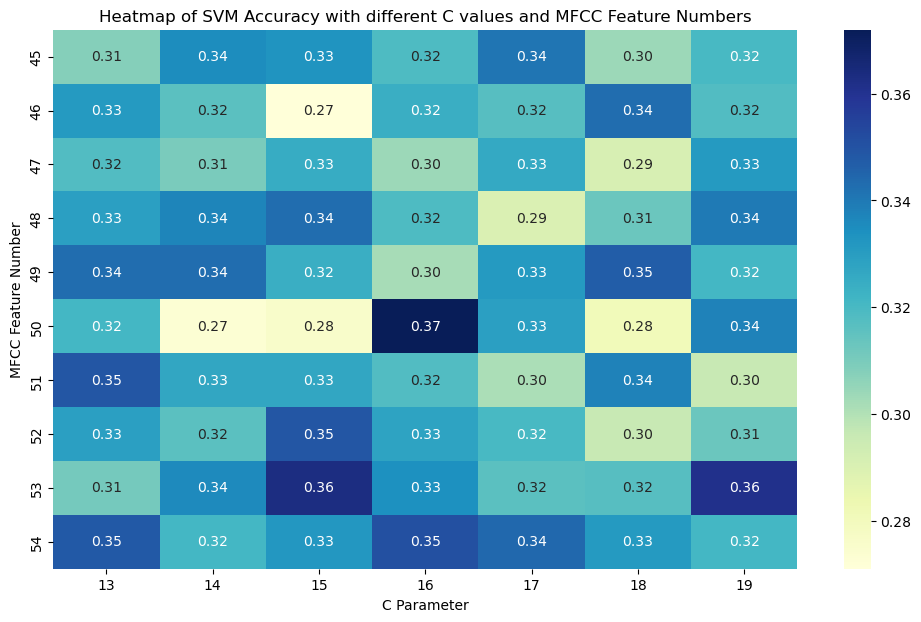

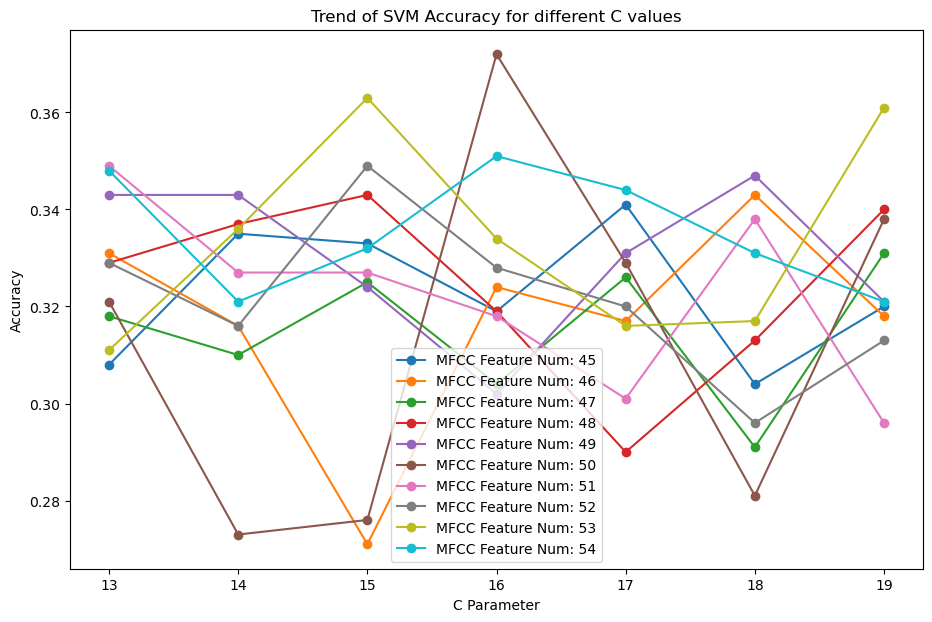

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(csv_filepath):
    # Load the results from a CSV file into a DataFrame
    results_df = pd.read_csv(csv_filepath)
    
    # Pivot the DataFrame to format suitable for heatmap
    heatmap_data = results_df.pivot(index="MFCC_Feature_Num", columns="C", values="Accuracy")
    
    # Plot the heatmap
    plt.figure(figsize=(12, 7))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title('Heatmap of SVM Accuracy with different C values and MFCC Feature Numbers')
    plt.xlabel('C Parameter')
    plt.ylabel('MFCC Feature Number')
    plt.show()
    
    
    plt.figure(figsize=(11, 7))
    for feature_num in results_df["MFCC_Feature_Num"].unique():
        subset = results_df[results_df['MFCC_Feature_Num'] == feature_num]
        plt.plot(subset['C'], subset['Accuracy'], marker='o', label=f'MFCC Feature Num: {feature_num}')
    
    plt.title('Trend of SVM Accuracy for different C values')
    plt.xlabel('C Parameter')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

plot_heatmap('svm_training_results.csv')



